<a href="https://colab.research.google.com/github/MannyMols/Hadoop/blob/main/ML_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Now, your Google Drive is mounted and you can read the 'Ml dataset' CSV file into a Pandas DataFrame.
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from sklearn.feature_selection import f_classif, chi2, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os

# Assuming the 'Ml dataset' is at the root of your Google Drive, adjust the path if it's in a different folder.
file_path = '/content/drive/My Drive/ML-EdgeIIoT-dataset.csv'

# Read the CSV file into a DataFrame
# By default, pandas uses a low memory mode when reading CSV files, which can cause issues with mixed data types.
# Setting low_memory=False disables the low memory mode and allows pandas to read the entire file into memory before inferring data types.
data = pd.read_csv(file_path, low_memory=False)

# Check shape and summary
print(data.shape)
print(data.info())
print(data.describe())


Mounted at /content/drive
(157800, 63)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   frame.time                 157800 non-null  object 
 1   ip.src_host                157800 non-null  object 
 2   ip.dst_host                157800 non-null  object 
 3   arp.dst.proto_ipv4         157800 non-null  object 
 4   arp.opcode                 157800 non-null  float64
 5   arp.hw.size                157800 non-null  float64
 6   arp.src.proto_ipv4         157800 non-null  object 
 7   icmp.checksum              157800 non-null  float64
 8   icmp.seq_le                157800 non-null  float64
 9   icmp.transmit_timestamp    157800 non-null  float64
 10  icmp.unused                157800 non-null  float64
 11  http.file_data             157800 non-null  object 
 12  http.content_length        157800 non-null  flo

In [2]:
%%time
# Columns to drop from DataFrame is named 'df'
columns_to_drop = [
    'frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
    'arp.src.proto_ipv4', 'icmp.checksum', 'icmp.seq_le', 'icmp.transmit_timestamp',
    'icmp.unused', 'http.file_data', 'http.request.uri.query', 'http.request.method',
    'http.referer', 'http.request.full_uri', 'http.request.version', 'http.response',
    'tcp.checksum', 'tcp.options', 'tcp.payload', 'udp.stream', 'udp.time_delta',
    'dns.qry.name', 'dns.qry.name.len', 'dns.retransmission', 'dns.retransmit_request',
    'dns.retransmit_request_in', 'mqtt.conack.flags', 'mqtt.msg_decoded_as', 'mqtt.msg',
    'mqtt.protoname', 'mqtt.topic', 'mbtcp.trans_id', 'mbtcp.unit_id'
]

# Drop the specified columns
df = data.drop(columns=columns_to_drop)

# Print the updated DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   arp.opcode              157800 non-null  float64
 1   arp.hw.size             157800 non-null  float64
 2   http.content_length     157800 non-null  float64
 3   http.tls_port           157800 non-null  float64
 4   tcp.ack                 157800 non-null  float64
 5   tcp.ack_raw             157800 non-null  float64
 6   tcp.connection.fin      157800 non-null  float64
 7   tcp.connection.rst      157800 non-null  float64
 8   tcp.connection.syn      157800 non-null  float64
 9   tcp.connection.synack   157800 non-null  float64
 10  tcp.dstport             157800 non-null  float64
 11  tcp.flags               157800 non-null  float64
 12  tcp.flags.ack           157800 non-null  float64
 13  tcp.len                 157800 non-null  float64
 14  tcp.seq             

In [3]:
%%time
label_counts = df['Attack_type'].value_counts() #Total number of outut and frequencies
print(label_counts)

Attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64
CPU times: user 8.65 ms, sys: 0 ns, total: 8.65 ms
Wall time: 8.98 ms


In [4]:
%%time

# Define a regular expression pattern to match the entries to be eliminated
pattern = r'DESKTOP-UHF0SF2|DESKTOP-UHF0SF2\.local|_googlecast\._tcp\.local'

# Create a boolean mask indicating which rows have the specified entries in 'tcp.srcport'
mask = df['tcp.srcport'].str.contains(pattern, regex=True)

# Replace the specified entries with a default value (e.g., 0)
df.loc[mask, 'tcp.srcport'] = 0

# Convert the 'tcp.srcport' column to numeric data type
df['tcp.srcport'] = pd.to_numeric(df['tcp.srcport'], errors='coerce')

# Print the updated DataFrame
#print(df)

CPU times: user 63.6 ms, sys: 0 ns, total: 63.6 ms
Wall time: 65.7 ms


In [5]:
%%time
# Data features
X = df.drop(['Attack_label', 'Attack_type'], axis=1)

# Target Variable
y = df['Attack_type'] # for multi-class classification (types of attacks).

#X.info()

CPU times: user 4.81 ms, sys: 4.11 ms, total: 8.92 ms
Wall time: 9.15 ms


In [6]:
%%time

# Convert X to a DataFrame
#X = pd.DataFrame(X)

# Store the feature names
feature_names = X.columns

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X = constant_filter.fit_transform(X)

# Perform ANOVA F-test
with np.errstate(divide='ignore', invalid='ignore'):
    f_scores, p_values = f_classif(X, y)

# Create a DataFrame to store the ANOVA F-test results
anova_results = pd.DataFrame({'Feature': feature_names[constant_filter.get_support()], 'F-score': f_scores, 'p-value': p_values})

# Sort the results by F-score in descending order
anova_results = anova_results.sort_values('F-score', ascending=False)

print("ANOVA F-test results:")
print(anova_results)

# Perform Chi-Squared test
chi2_scores, p_values = chi2(X, y)

# Create a DataFrame to store the Chi-Squared test results
chi2_results = pd.DataFrame({'Feature': feature_names[constant_filter.get_support()], 'Chi2-score': chi2_scores, 'p-value': p_values})

# Sort the results by Chi2-score in descending order
chi2_results = chi2_results.sort_values('Chi2-score', ascending=False)

print("\nChi-Squared test results:")
print(chi2_results)

ANOVA F-test results:
                   Feature       F-score       p-value
10               tcp.flags  13121.586588  0.000000e+00
11           tcp.flags.ack  12038.253912  0.000000e+00
3                  tcp.ack   6334.830157  0.000000e+00
4              tcp.ack_raw   5376.709017  0.000000e+00
7       tcp.connection.syn   3717.469027  0.000000e+00
6       tcp.connection.rst   3253.471612  0.000000e+00
9              tcp.dstport   3117.015249  0.000000e+00
14             tcp.srcport   2200.444757  0.000000e+00
16              dns.qry.qu   1919.975688  0.000000e+00
12                 tcp.len   1358.312186  0.000000e+00
21            mqtt.msgtype   1053.240720  0.000000e+00
19           mqtt.hdrflags   1053.240720  0.000000e+00
5       tcp.connection.fin    979.716773  0.000000e+00
20                mqtt.len    904.167097  0.000000e+00
13                 tcp.seq    883.056044  0.000000e+00
1              arp.hw.size    572.120040  0.000000e+00
18           mqtt.conflags    517.045704  0

In [7]:
%%time

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert the NumPy array back to a DataFrame
df = pd.DataFrame(X)

CPU times: user 24.6 ms, sys: 1.9 ms, total: 26.5 ms
Wall time: 26.8 ms


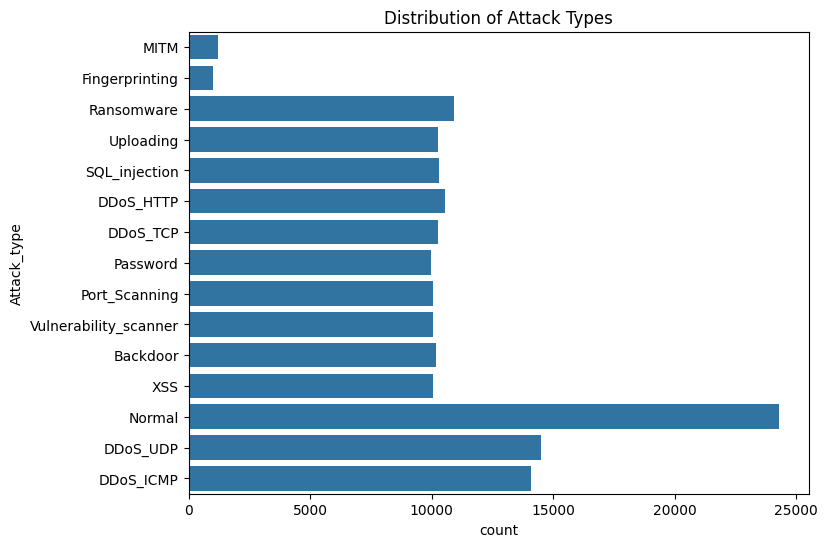

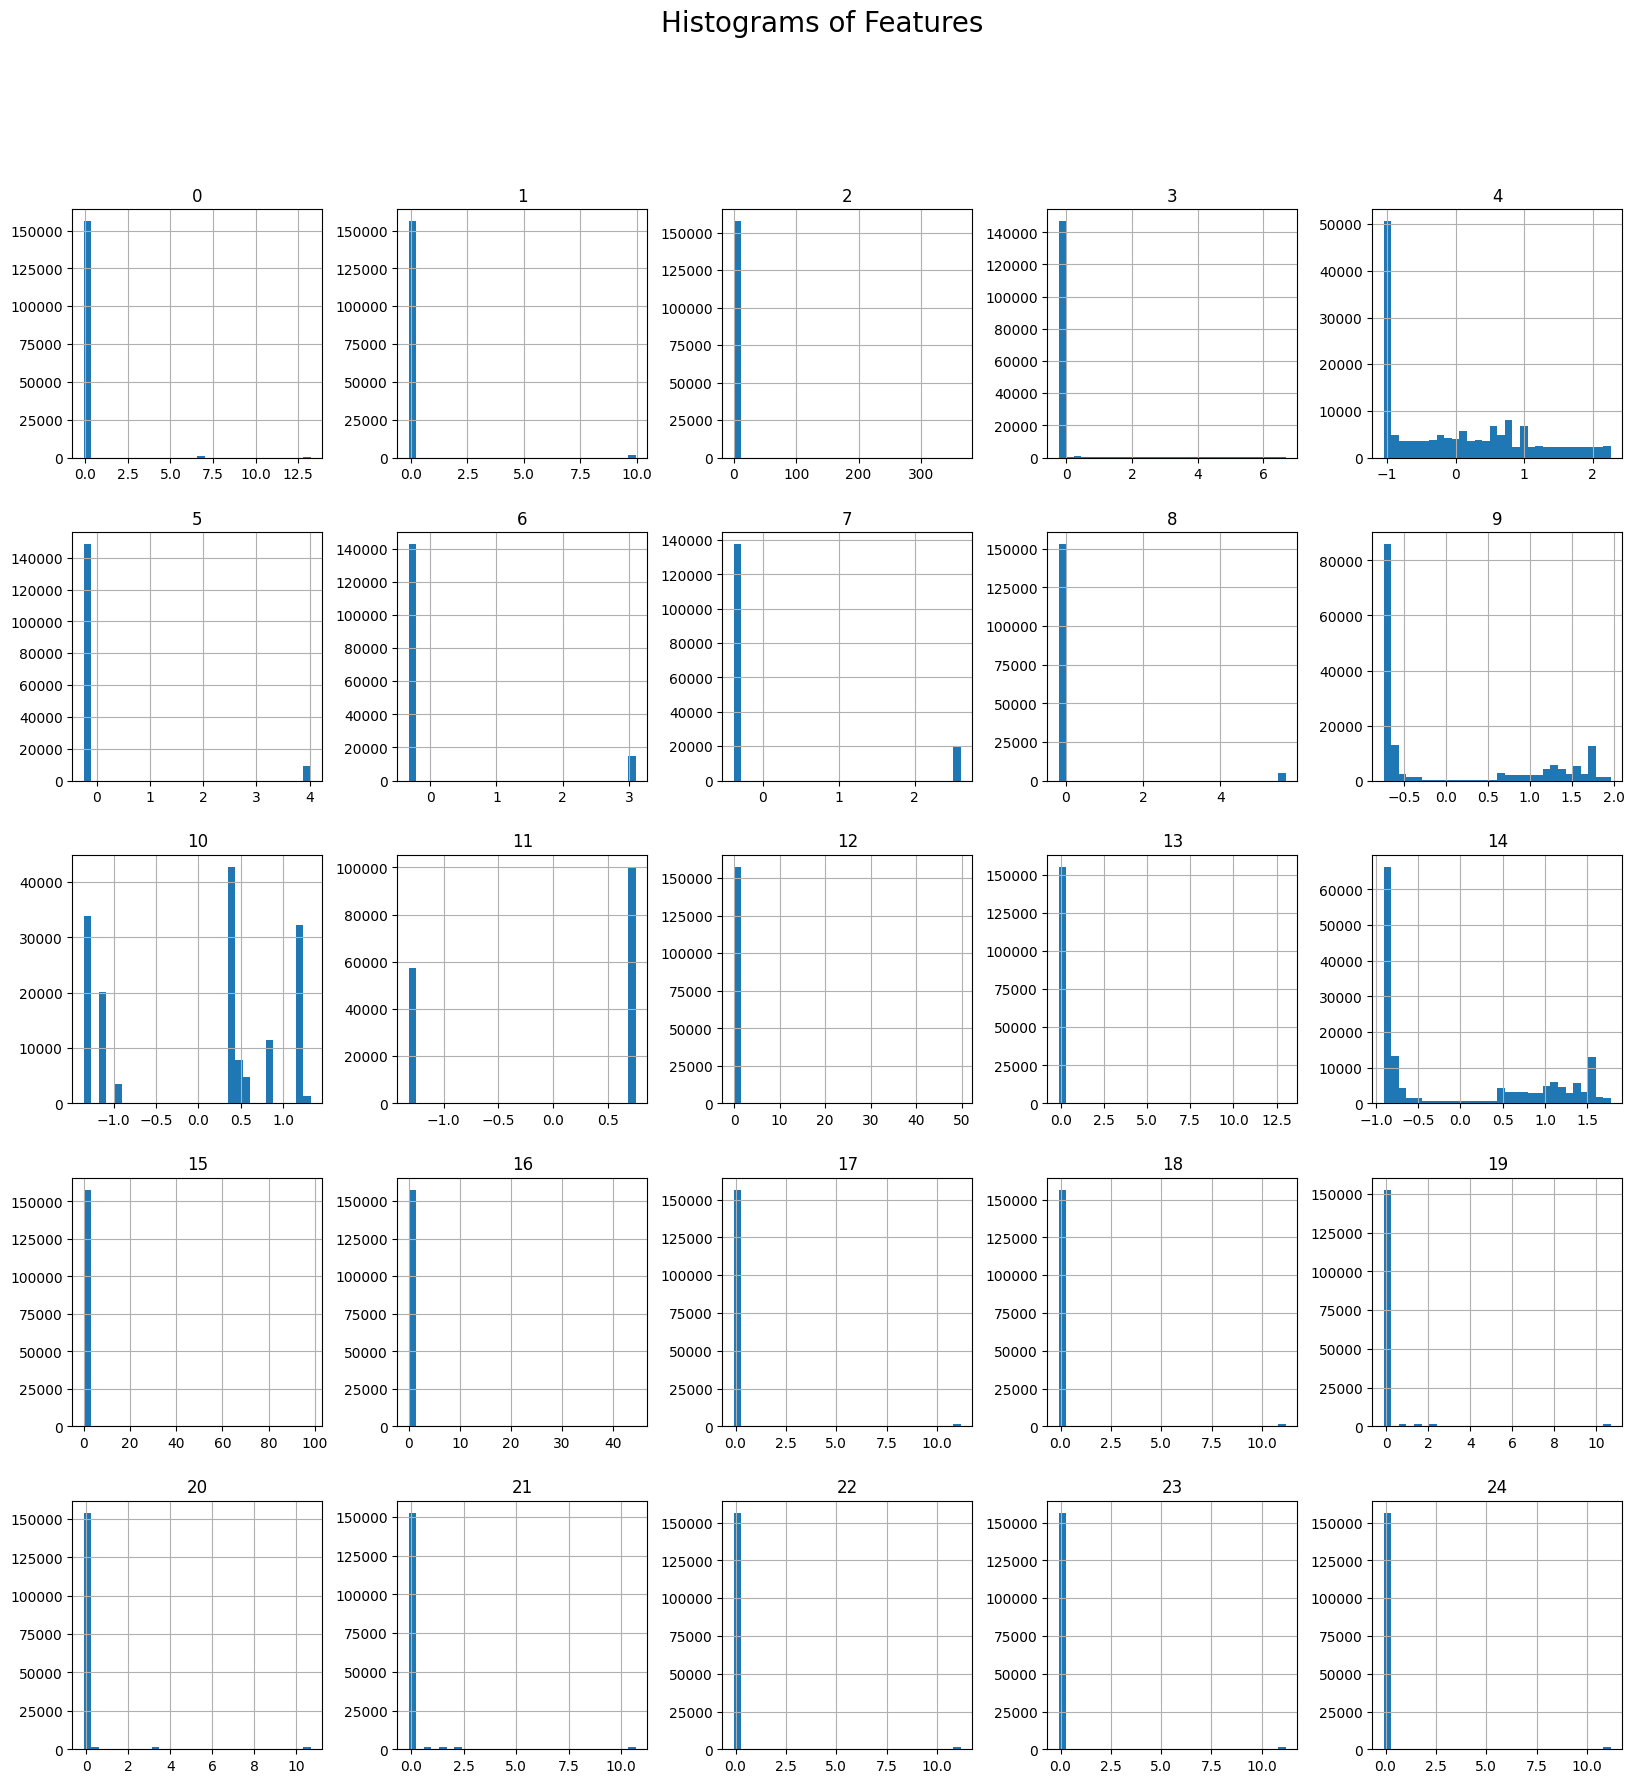

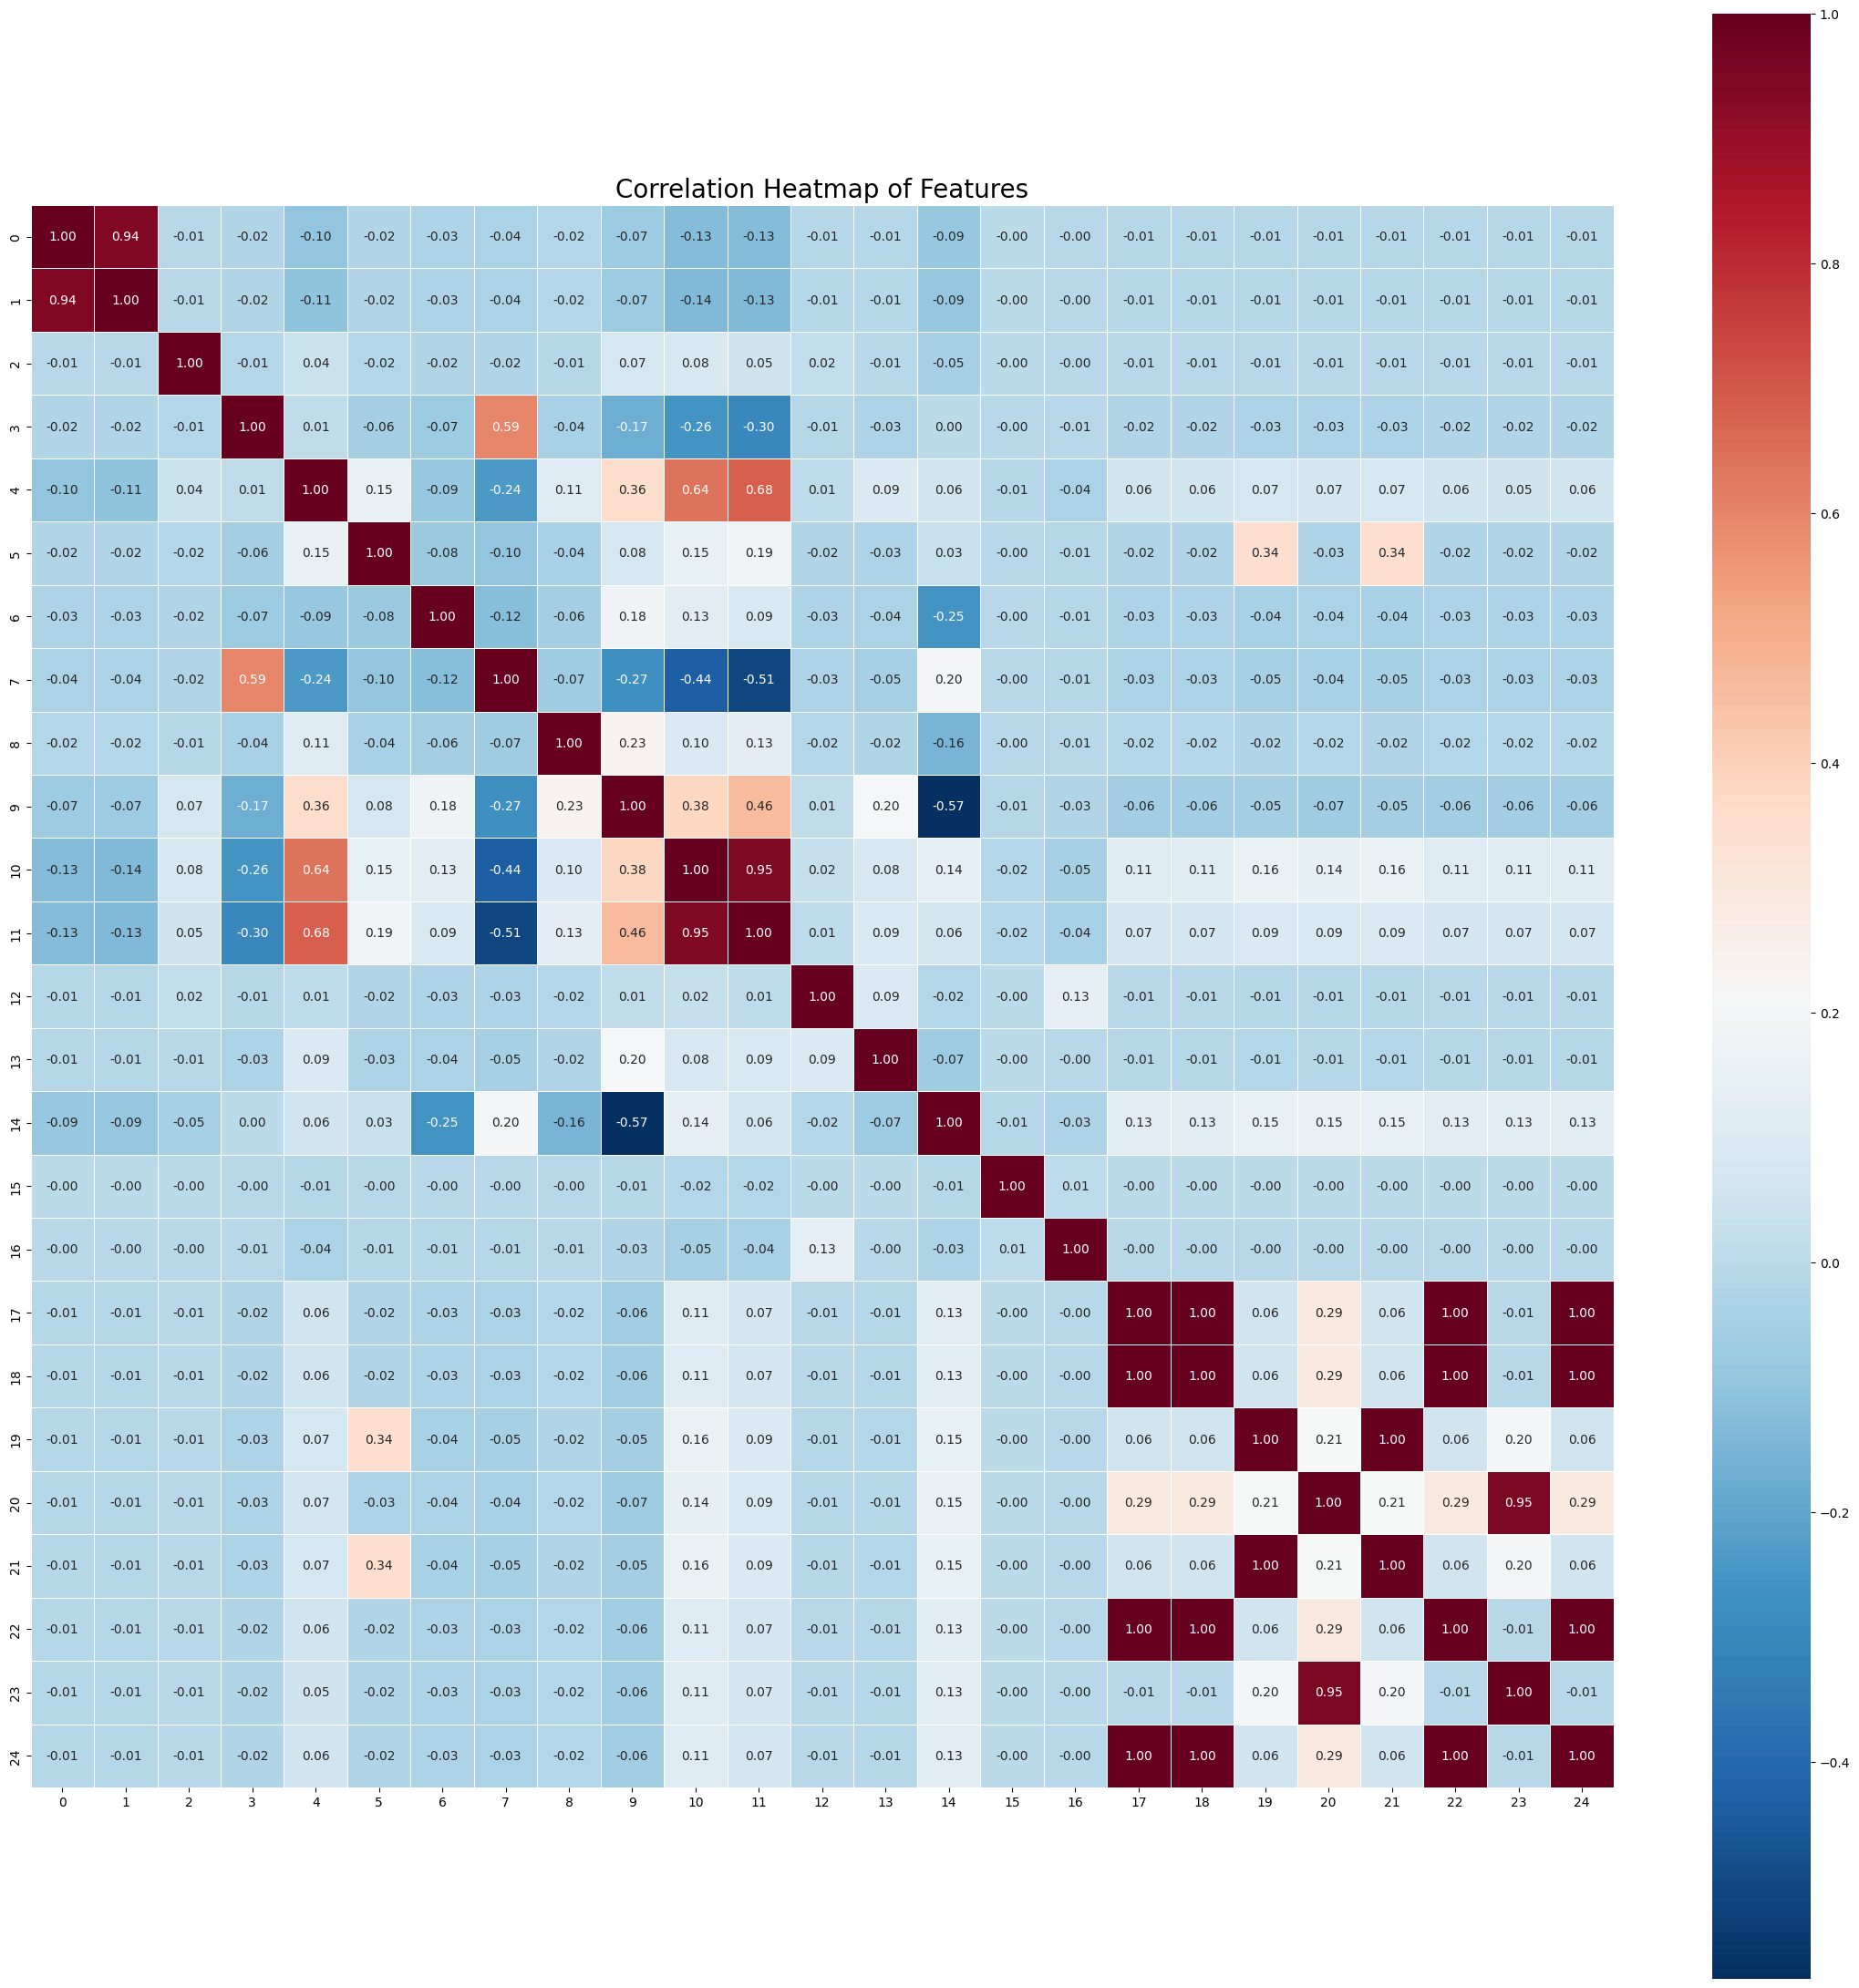

CPU times: user 6.31 s, sys: 377 ms, total: 6.69 s
Wall time: 6.44 s


In [8]:
%%time

# Visualize distribution of target variable
plt.figure(figsize=(8,6))
sns.countplot(y=y)
plt.title("Distribution of Attack Types")
plt.show()

# Plot histograms of features
df.hist(bins=30, figsize=(20,20))
plt.suptitle("Histograms of Features", fontsize=20)
plt.show()

# Compute correlation matrix
corr = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(28,28))
sns.heatmap(corr, cmap='RdBu_r', annot=True, fmt=".2f", annot_kws={'size':10},
            xticklabels=corr.columns, yticklabels=corr.columns, square=True, linewidth=0.5)
plt.title("Correlation Heatmap of Features", fontsize=20)
plt.show()

In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
1,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
2,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
3,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
4,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157795,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
157796,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
157797,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357
157798,-0.094772,-0.100375,-0.064076,-0.230878,-1.048497,-0.24846,-0.322332,-0.382876,-0.17571,-0.74375,...,-0.012631,-0.033762,-0.089357,-0.089357,-0.124729,-0.116271,-0.124729,-0.089357,-0.089213,-0.089357


SVM - Train Accuracy: 0.753, Validation Accuracy: 0.752, Test Accuracy: 0.753
KNN - Train Accuracy: 0.881, Validation Accuracy: 0.844, Test Accuracy: 0.845
MLP - Train Accuracy: 0.862, Validation Accuracy: 0.858, Test Accuracy: 0.858


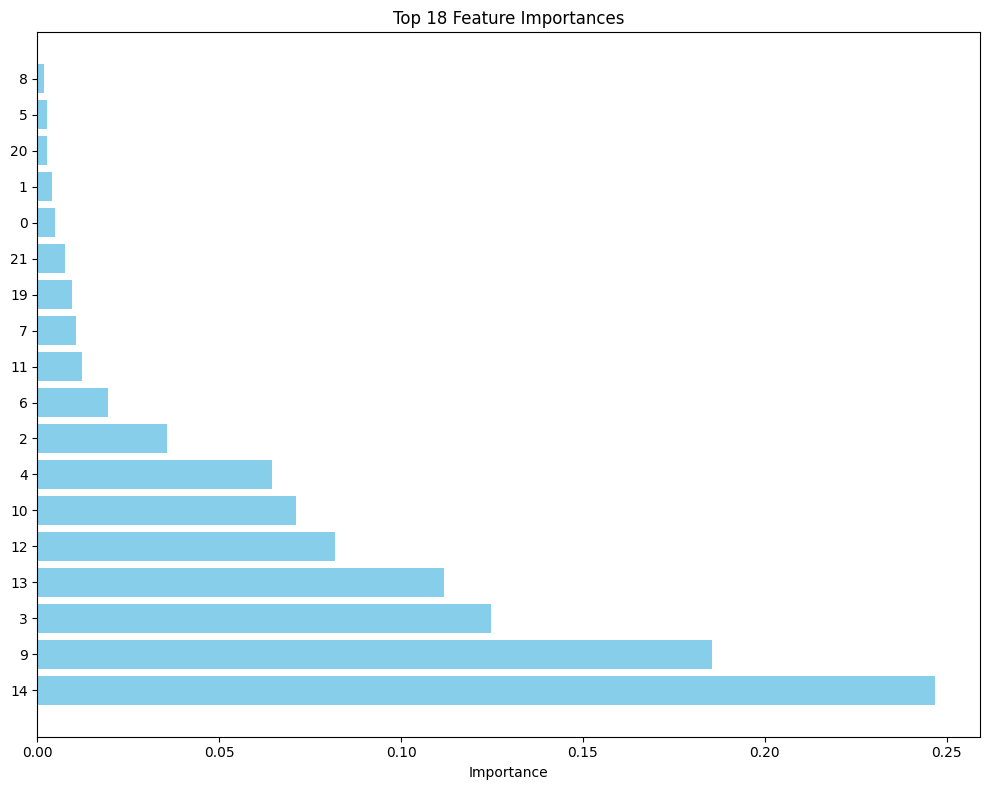

CPU times: user 16min 53s, sys: 1min 41s, total: 18min 35s
Wall time: 15min 58s


In [10]:
%%time

# Split the data into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets
val_size = 0.2  # Validation set size (20% of the training+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'

# Impute missing values in the training, validation, and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Check if the trained Random Forest model exists
if os.path.exists('rf_model.joblib'):
    # Load the trained model from disk
    rf = joblib.load('rf_model.joblib')
else:
    # Fit the Random Forest model on the imputed training data
    rf.fit(X_train_imputed, y_train)
    # Save the trained model to disk
    joblib.dump(rf, 'rf_model.joblib')

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = df.columns

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top N features (e.g., top 18)
top_n_features = 18
selected_features = feature_importances_df.head(top_n_features)

# Filter the imputed training, validation, and testing data with selected features
X_train_selected = X_train_imputed[:, selected_features.index]
X_val_selected = X_val_imputed[:, selected_features.index]
X_test_selected = X_test_imputed[:, selected_features.index]

# SVM
if os.path.exists('svm_model.joblib'):
    svm = joblib.load('svm_model.joblib')
else:
    svm = SVC()
    svm.fit(X_train_selected, y_train)
    joblib.dump(svm, 'svm_model.joblib')

svm_score_train = svm.score(X_train_selected, y_train)
svm_score_val = svm.score(X_val_selected, y_val)
svm_score_test = svm.score(X_test_selected, y_test)
print(f"SVM - Train Accuracy: {svm_score_train:.3f}, Validation Accuracy: {svm_score_val:.3f}, Test Accuracy: {svm_score_test:.3f}")

# KNN
if os.path.exists('knn_model.joblib'):
    knn = joblib.load('knn_model.joblib')
else:
    knn = KNeighborsClassifier()
    knn.fit(X_train_selected, y_train)
    joblib.dump(knn, 'knn_model.joblib')

knn_score_train = knn.score(X_train_selected, y_train)
knn_score_val = knn.score(X_val_selected, y_val)
knn_score_test = knn.score(X_test_selected, y_test)
print(f"KNN - Train Accuracy: {knn_score_train:.3f}, Validation Accuracy: {knn_score_val:.3f}, Test Accuracy: {knn_score_test:.3f}")

# MLP
if os.path.exists('mlp_model.joblib'):
    mlp = joblib.load('mlp_model.joblib')
else:
    mlp = MLPClassifier(max_iter=500)
    mlp.fit(X_train_selected, y_train)
    joblib.dump(mlp, 'mlp_model.joblib')

mlp_score_train = mlp.score(X_train_selected, y_train)
mlp_score_val = mlp.score(X_val_selected, y_val)
mlp_score_test = mlp.score(X_test_selected, y_test)
print(f"MLP - Train Accuracy: {mlp_score_train:.3f}, Validation Accuracy: {mlp_score_val:.3f}, Test Accuracy: {mlp_score_test:.3f}")

# Visualize the top 18 feature importances
plt.figure(figsize=(10, 8))
plt.title("Top 18 Feature Importances")
plt.barh(range(len(selected_features)), selected_features['Importance'], color='skyblue', align='center')
plt.yticks(range(len(selected_features)), selected_features['Feature'])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [11]:
%%time

# Split the data into training+validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an imputer object
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'

# Impute missing values in the training+validation and testing data
X_train_val_imputed = imputer.fit_transform(X_train_val)
X_test_imputed = imputer.transform(X_test)

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the Random Forest model on the imputed training+validation data
rf.fit(X_train_val_imputed, y_train_val)

# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = df.columns

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top N features (e.g., top 18)
top_n_features = 18
selected_features = feature_importances_df.head(top_n_features)

# Filter the imputed training+validation and testing data with selected features
X_train_val_selected = X_train_val_imputed[:, selected_features.index]
X_test_selected = X_test_imputed[:, selected_features.index]

# Define parameter distributions for hyperparameter tuning
svm_param_dist = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
knn_param_dist = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
mlp_param_dist = {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001, 0.01]}

# Perform randomized search and hyperparameter tuning for each model
models = [
    ('SVM', SVC(), svm_param_dist),
    ('KNN', KNeighborsClassifier(), knn_param_dist),
    ('MLP', MLPClassifier(max_iter=500), mlp_param_dist)
]

for name, model, param_dist in models:
    model_filename = f"{name.lower()}_model.joblib"

    try:
        # Try to load the saved model
        best_model = joblib.load(model_filename)
        print(f"Loaded {name} model from file.")
    except FileNotFoundError:
        print(f"Randomized search and hyperparameter tuning for {name}:")

        # Perform randomized search with cross-validation
        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
        random_search.fit(X_train_val_selected, y_train_val)

        # Get the best model and its parameters
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        # Print the best parameters
        print(f"Best parameters: {best_params}")

        # Save the best model using joblib
        joblib.dump(best_model, model_filename)
        print(f"Saved {name} model to file.")

    # Evaluate the best model on the testing set
    y_pred = best_model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Test accuracy: {accuracy:.3f}")
    print(classification_report(y_test, y_pred))
    print()

Loaded SVM model from file.
Test accuracy: 0.726
                       precision    recall  f1-score   support

             Backdoor       0.92      0.89      0.91      1973
            DDoS_HTTP       0.47      0.57      0.52      2129
            DDoS_ICMP       0.73      1.00      0.85      2836
             DDoS_TCP       1.00      0.82      0.90      1961
             DDoS_UDP       1.00      0.87      0.93      2904
       Fingerprinting       1.00      0.30      0.46       197
                 MITM       1.00      0.31      0.47       255
               Normal       0.70      0.82      0.76      4985
             Password       0.66      0.17      0.27      1973
        Port_Scanning       0.85      0.88      0.87      2128
           Ransomware       1.00      0.77      0.87      2061
        SQL_injection       0.48      0.88      0.63      2089
            Uploading       0.58      0.33      0.42      2015
Vulnerability_scanner       0.97      0.79      0.87      2009
     